For training your model you’ll typically use the labeled data. In this case, the main file to focus on is:

train.csv (File #8)
The other files may be used for:

Evaluation or further analysis:
For instance, the test files (Files #4, #5, and #6) can be used for testing or validation.

Additional features or biases:
Files #2 and #7 (identity_individual_annotations.csv and toxicity_individual_annotations.csv) can help address bias or incorporate additional features.

Submission template:
File #3 (sample_submission.csv) is usually for organizing your submission.

Complete dataset:
File #1 (all_data.csv) may offer more extensive coverage, depending on your intended use case.

In [6]:
import os
import pandas as pd
import gdown
import string
import re
import nltk
import spacy
from tqdm.notebook import tqdm

# Download NLTK resources if not already available
nltk.download('punkt')

# Load spaCy model (make sure to run: python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

def vectorized_clean(series):
    """
    Use vectorized operations to lowercase and remove punctuation.
    """
    pattern = f"[{re.escape(string.punctuation)}]"
    return series.str.lower().str.replace(pattern, '', regex=True)

def spacy_tokenize(texts, batch_size=500):
    """
    Use spaCy's nlp.pipe to tokenize text in batches.
    """
    clean_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=1), total=len(texts)):
        tokens = [token.text for token in doc if not token.is_space]
        clean_texts.append(" ".join(tokens))
    return clean_texts

# Create directories if they don't exist
raw_dir = os.path.join("../raw_data", "jigsaw_unintended")
processed_dir = os.path.join("../processed_data", "jigsaw_unintended")
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Download train.csv using the direct download link
train_url = 'https://drive.google.com/uc?export=download&id=1N-orSYsJCubW2SXLXVukT9zfFf8aAg-C'
train_file = os.path.join(raw_dir, 'train.csv')
cleaned_train = os.path.join(processed_dir, 'cleaned_train.csv')

# Check if the file exists before downloading
if not os.path.exists(train_file):
    gdown.download(train_url, train_file, quiet=False)
else:
    print(f"{train_file} already exists; skipping download.")


# Check if the cleaned file already exists
if os.path.exists(cleaned_train):
    print(f"{cleaned_train} already exists; skipping processing.")
else:
    # Process the file in chunks if it's too large
    chunk_size = 10**6  # Adjust based on your memory capacity
    processed_chunks = []

    for chunk in pd.read_csv(train_file, chunksize=chunk_size):
        # Remove duplicates and fill missing values
        chunk.drop_duplicates(inplace=True)
        chunk.fillna('', inplace=True)
        
        if 'comment_text' in chunk.columns:
            # Vectorized cleaning: lowercase & remove punctuation
            chunk['comment_text'] = vectorized_clean(chunk['comment_text'])
            
            # Option 1: If tokenization isn't strictly needed here, comment out the next block.
            # Option 2: If tokenization is needed, use spaCy's nlp.pipe for improved performance.
            texts = chunk['comment_text'].tolist()
            chunk['comment_text'] = spacy_tokenize(texts, batch_size=500)
        
        processed_chunks.append(chunk)

    # Concatenate all processed chunks and save the cleaned data
    df = pd.concat(processed_chunks)
    cleaned_train = os.path.join(processed_dir, 'cleaned_train.csv')
    df.to_csv(cleaned_train, index=False)

    print(f"Cleaned data saved to {cleaned_train}")

# Define file names and their corresponding Google Drive direct download URLs
files = {
    "test_private_expanded.csv": "https://drive.google.com/uc?export=download&id=1bAOCveaQZ1s0WI3OKBDh_xevKqtLB5vv",
    "test_public_expanded.csv": "https://drive.google.com/uc?export=download&id=1w4Sh6m16BttINP3aVqbFtpQcvECtilho",
    "test.csv": "https://drive.google.com/uc?export=download&id=1oivL4ZYsABBqbDFM3KyZJH8mOHPx_q7O"
}

# Download each file if it does not exist locally
for filename, url in files.items():
    filepath = os.path.join(raw_dir, filename)
    if not os.path.exists(filepath):
        print(f"Downloading {filename}...")
        gdown.download(url, filepath, quiet=False)
    else:
        print(f"{filename} already exists; skipping download.")
print("All files are downloaded and ready.")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/crownedprinz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


../raw_data/jigsaw_unintended/train.csv already exists; skipping download.
../processed_data/jigsaw_unintended/cleaned_train.csv already exists; skipping processing.
test_private_expanded.csv already exists; skipping download.
test_public_expanded.csv already exists; skipping download.
test.csv already exists; skipping download.
All files are downloaded and ready.


3. Exploratory Data Analysis (EDA)
	1.	Summary Statistics
	•	Distribution of the target (toxicity) score or your new binary label.
	•	Comment length distributions (e.g., average words per comment).
	2.	Identity Attributes (if relevant)
	•	If you’re examining bias, check how often each identity (e.g., male, female, christian, etc.) appears.
	•	Look for imbalances: Are some identities underrepresented?
	3.	Visualizations
	•	Word clouds for toxic vs. non-toxic comments.
	•	Bar plots of identity frequency or other relevant features.

Average words per comment: 51.70


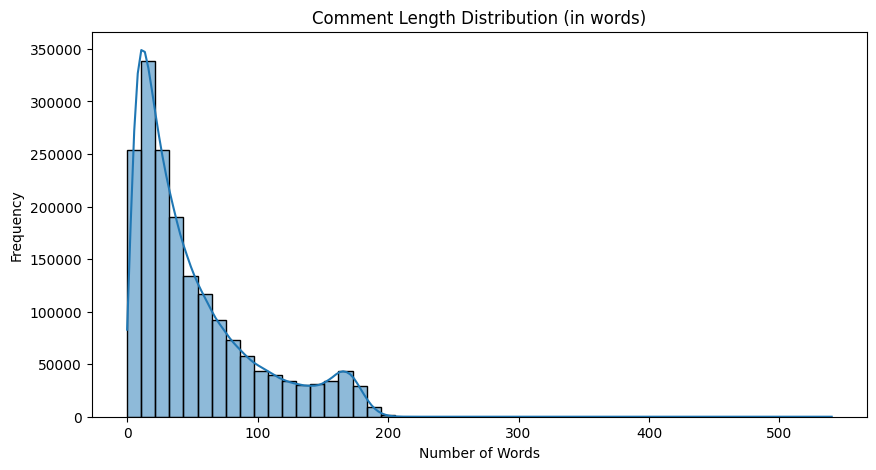

Identity Attributes (average values):
male         0.108687
female       0.127670
christian    0.095268
jewish       0.017863
muslim       0.049460
dtype: float64


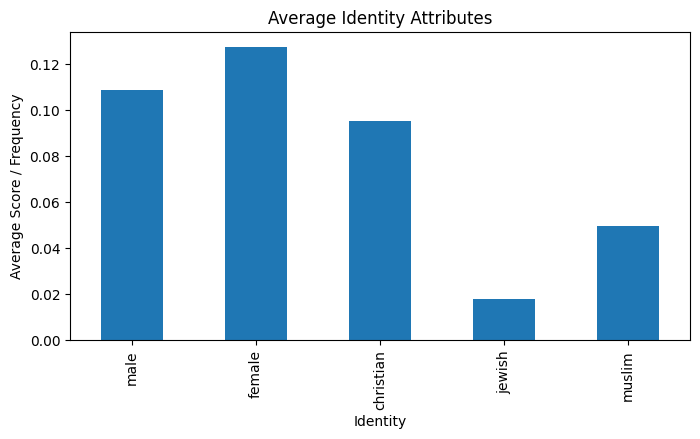

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# File path for cleaned data
cleaned_train = os.path.join("../processed_data", "jigsaw_unintended", "cleaned_train.csv")

# Load the cleaned dataset
df = pd.read_csv(cleaned_train)

# ===========================
# 1. Summary Statistics
# ===========================
if 'toxicity' in df.columns:
    print("Toxicity Summary Statistics:")
    print(df['toxicity'].describe())
    
    plt.figure(figsize=(8, 4))
    df['toxicity'].value_counts().plot(kind='bar')
    plt.title('Distribution of Toxicity')
    plt.xlabel('Toxicity Label')
    plt.ylabel('Count')
    plt.show()

# ===========================
# 2. Comment Length Distribution
# ===========================
if 'comment_text' in df.columns:
    # Compute word count for each comment# Compute word count for each comment, ensuring a string is used
    df['word_count'] = df['comment_text'].fillna("").apply(lambda x: len(str(x).split()))   
    print(f"Average words per comment: {df['word_count'].mean():.2f}")
    
    plt.figure(figsize=(10, 5))
    sns.histplot(df['word_count'], bins=50, kde=True)
    plt.title('Comment Length Distribution (in words)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

# ===========================
# 3. Identity Attributes (if available)
# ===========================
# List any identity-related columns you expect to see in your dataset.
identity_cols = ['male', 'female', 'christian', 'jewish', 'muslim']
identity_cols = [col for col in identity_cols if col in df.columns]

if identity_cols:
    print("Identity Attributes (average values):")
    print(df[identity_cols].mean())
    
    plt.figure(figsize=(8, 4))
    df[identity_cols].mean().plot(kind='bar')
    plt.title('Average Identity Attributes')
    plt.xlabel('Identity')
    plt.ylabel('Average Score / Frequency')
    plt.show()

# ===========================
# 4. Word Clouds for Toxic vs. Non-Toxic Comments
# ===========================
# Define a threshold to separate toxic from non-toxic comments.
# Adjust the threshold based on your label encoding.
if 'toxicity' in df.columns and 'comment_text' in df.columns:
    toxic_comments = " ".join(df[df['toxicity'] > 0.5]['comment_text'].astype(str).tolist())
    non_toxic_comments = " ".join(df[df['toxicity'] <= 0.5]['comment_text'].astype(str).tolist())
    
    wordcloud_toxic = WordCloud(width=800, height=400,
                                stopwords=set(STOPWORDS),
                                background_color='white').generate(toxic_comments)
    
    wordcloud_non_toxic = WordCloud(width=800, height=400,
                                    stopwords=set(STOPWORDS),
                                    background_color='white').generate(non_toxic_comments)
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_toxic, interpolation='bilinear')
    plt.axis('off')
    plt.title('Toxic Comments Word Cloud')
    
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
    plt.axis('off')
    plt.title('Non-Toxic Comments Word Cloud')
    
    plt.show()

Baseline Model Development on Separate Datasets 
* use the model of your choice in the excel sheet we created to work on your dataset 
* train the model, and output performance metrics.
* Write functions or classes so that your training code accepts a dataset as input and outputs a trained model along with evaluation metrics.

Cross-Dataset Evaluation
* For your model trained on one dataset, try to test it on all other datasets.
* ⁠Automate the evaluation to compute metrics (accuracy, precision, recall, F1-score) for each cross-dataset combination.

In [11]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib

model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

#################################
# Baseline (Single-Stage) Model
#################################
def train_model(df, text_col="comment_text", label_col="target", test_size=0.2, random_state=42, threshold=0.5):
    """
    Train a baseline text classifier for toxicity (binary).
    """
    df[text_col] = df[text_col].astype(str).fillna("")
    df[label_col] = df[label_col].fillna(0.0)
    # Create binary label from continuous target using threshold
    df["binary_label"] = df[label_col].apply(lambda x: 1 if float(x) > threshold else 0)
    
    X = df[text_col]
    y = df["binary_label"]
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', LogisticRegression(max_iter=500))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    metrics = {
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred, pos_label=1),
        "recall": recall_score(y_val, y_pred, pos_label=1),
        "f1": f1_score(y_val, y_pred, pos_label=1)
    }
    print("Baseline Model: Validation Metrics:")
    print(classification_report(y_val, y_pred))
    
    return pipeline, metrics

def evaluate_cross_datasets(model, datasets, text_col="comment_text", label_col="target", threshold=0.5):
    """
    Evaluate a trained model on multiple datasets.
    
    For datasets without the ground truth label (target), only the prediction distribution is printed.
    """
    results = {}
    
    for name, df in datasets.items():
        print(f"\nEvaluating dataset '{name}'...")
        df[text_col] = df[text_col].astype(str).fillna("")
        
        if label_col in df.columns:
            df[label_col] = df[label_col].fillna(0.0)
            df["binary_label"] = df[label_col].apply(lambda x: 1 if float(x) > threshold else 0)
            
            X = df[text_col]
            y = df["binary_label"]
            
            y_pred = model.predict(X)
            metrics = {
                "accuracy": accuracy_score(y, y_pred),
                "precision": precision_score(y, y_pred, pos_label=1),
                "recall": recall_score(y, y_pred, pos_label=1),
                "f1": f1_score(y, y_pred, pos_label=1)
            }
            print("Evaluation Metrics:")
            print(classification_report(y, y_pred))
            results[name] = metrics
        else:
            predictions = model.predict(df[text_col])
            df["predicted_label"] = predictions
            print("No ground truth provided. Prediction distribution:")
            print(df["predicted_label"].value_counts())
            results[name] = {"predictions": predictions.tolist()}
            
    return results

############################################
# Two-Stage Model: Binary and Multiclass
############################################
def train_binary_model(df, text_col="comment_text", label_col="target", test_size=0.2, random_state=42, threshold=0.5):
    """
    Stage 1: Train a binary classifier to flag toxic comments.
    """
    df[text_col] = df[text_col].astype(str).fillna("")
    df[label_col] = df[label_col].fillna(0.0)
    df["binary_label"] = df[label_col].apply(lambda x: 1 if float(x) > threshold else 0)
    
    X = df[text_col]
    y = df["binary_label"]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
   # For binary model:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    metrics = {
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred, pos_label=1),
        "recall": recall_score(y_val, y_pred, pos_label=1),
        "f1": f1_score(y_val, y_pred, pos_label=1)
    }
    print("Stage 1 (Binary): Validation Metrics:")
    print(classification_report(y_val, y_pred))
    return pipeline, metrics

def create_subtype_label(df, threshold=0.5):
    """
    Create a hate speech subtype label for toxic comments based on several attributes.
    
    Priority order: severe_toxicity/threat (combined), obscene, identity_attack, insult.
    If none exceed the threshold, label as 'other'.
    """
    def assign_label(row):
        # Combine severe_toxicity and threat due to their rarity
        if float(row.get("severe_toxicity", 0)) > threshold or float(row.get("threat", 0)) > threshold:
            return "severe_threat"
        elif float(row.get("obscene", 0)) > threshold:
            return "obscene"
        elif float(row.get("identity_attack", 0)) > threshold:
            return "identity_attack"
        elif float(row.get("insult", 0)) > threshold:
            return "insult"
        else:
            return "other"
    df["subtype_label"] = df.apply(assign_label, axis=1)
    return df

def train_multiclass_model(df, text_col="comment_text", threshold=0.5, test_size=0.2, random_state=42):
    """
    Stage 2: Train a multiclass classifier on toxic comments to predict hate speech subtype.
    
    Only toxic examples (target > threshold) are used.
    """
    df[text_col] = df[text_col].astype(str).fillna("")
    # Filter toxic samples only
    df = df[df["target"].astype(float) > threshold].copy()
    if df.empty:
        raise ValueError("No toxic samples found using the threshold provided.")
    
    # Create subtype labels from additional columns (e.g., severe_toxicity, obscene, etc.)
    df = create_subtype_label(df, threshold=threshold)
    
    X = df[text_col]
    y = df["subtype_label"]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # For multiclass model:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial'))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    print("Stage 2 (Multiclass Subtype): Validation Metrics:")
    # Add zero_division=0 to suppress the warning
    print(classification_report(y_val, y_pred, zero_division=0))
    
    return pipeline, classification_report(y_val, y_pred, zero_division=0)
#####################################################
# Main
#####################################################
if __name__ == "__main__":
    # Ensure working directory is correctly set if needed
    # os.chdir("/Users/crownedprinz/Documents/Projects/Python/dual-stage-toxic-comment-detection-system")
    
    # Load the cleaned training data
    train_df = pd.read_csv("../processed_data/jigsaw_unintended/cleaned_train.csv")
    
    # --- Baseline single-stage training ---
    print("Training Baseline Model (Single-Stage Binary):")
    baseline_model, baseline_metrics = train_model(train_df, text_col="comment_text", label_col="target", threshold=0.5)

    # 6. Save Model
    model_path = os.path.join(model_dir, 'toxic_comment_classifier_baseline_model.joblib') 
    joblib.dump(baseline_model, model_path)
    print(f"\nBaseline baseline_model training saved to: {model_path}")
    
    # Load test datasets (downloaded externally into ../raw_data/jigsaw_unintended)
    raw_dir = os.path.join("../raw_data", "jigsaw_unintended")
    test_private = pd.read_csv(os.path.join(raw_dir, "test_private_expanded.csv"))
    test_public = pd.read_csv(os.path.join(raw_dir, "test_public_expanded.csv"))
    test_standard = pd.read_csv(os.path.join(raw_dir, "test.csv"))
    
    datasets = {
        "Test Private": test_private,
        "Test Public": test_public,
        "Test Standard": test_standard
    }
    
    print("\nEvaluating Baseline Model on Test Datasets:")
    baseline_results = evaluate_cross_datasets(baseline_model, datasets, text_col="comment_text", label_col="target", threshold=0.5)
    
    # --- Two-Stage Model Training ---
    print("\nTraining Two-Stage Model - Stage 1 (Binary Classifier):")
    binary_model, binary_metrics = train_binary_model(train_df, text_col="comment_text", label_col="target", threshold=0.5)
    model_path = os.path.join(model_dir, 'toxic_comment_classifier_binary_metrics.joblib') 
    joblib.dump(binary_model, model_path)
    print(f"\nBaseline binary_metrics training saved to: {model_path}")
    
    print("\nTraining Two-Stage Model - Stage 2 (Multiclass Subtype Classifier):")
    multiclass_model, multiclass_metrics = train_multiclass_model(train_df, text_col="comment_text", threshold=0.5)
    
    model_path = os.path.join(model_dir, 'toxic_comment_classifier_multi_class.joblib') 
    joblib.dump(multiclass_model, model_path)
    print(f"\nBaseline multiclass_metrics training saved to: {model_path}")
    # --- Two-Stage Inference Example ---
    sample_comments = [
        "This comment is very toxic and awful!",
        "This is a nice comment, thank you."
    ]
    print("\nTwo-Stage Inference:")
    binary_preds = binary_model.predict(sample_comments)
    for comment, pred in zip(sample_comments, binary_preds):
        print("\nComment:", comment)
        print("Binary Prediction:", pred)
        if pred == 1:  # Toxic comment detected
            subtype_pred = multiclass_model.predict([comment])
            print("Subtype Prediction:", subtype_pred[0])
        else:
            print("Non-toxic comment; no subtype prediction.")

Training Baseline Model (Single-Stage Binary):
Baseline Model: Validation Metrics:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    339687
           1       0.79      0.45      0.57     21288

    accuracy                           0.96    360975
   macro avg       0.88      0.72      0.77    360975
weighted avg       0.96      0.96      0.95    360975


Baseline baseline_model training saved to: ../models/toxic_comment_classifier_baseline_model.joblib

Evaluating Baseline Model on Test Datasets:

Evaluating dataset 'Test Private'...
No ground truth provided. Prediction distribution:
predicted_label
0    93977
1     3343
Name: count, dtype: int64

Evaluating dataset 'Test Public'...
No ground truth provided. Prediction distribution:
predicted_label
0    94029
1     3291
Name: count, dtype: int64

Evaluating dataset 'Test Standard'...
No ground truth provided. Prediction distribution:
predicted_label
0    93977
1     3343
Name: count

/Users/crownedprinz/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Stage 2 (Multiclass Subtype): Validation Metrics:
                 precision    recall  f1-score   support

identity_attack       0.53      0.76      0.63      1347
         insult       0.91      0.75      0.83     14361
        obscene       0.58      0.75      0.65      1481
          other       0.36      0.45      0.40      3557
  severe_threat       0.38      0.77      0.51       542

       accuracy                           0.70     21288
      macro avg       0.55      0.70      0.60     21288
   weighted avg       0.76      0.70      0.72     21288


Baseline multiclass_metrics training saved to: ../models/toxic_comment_classifier_multi_class.joblib

Two-Stage Inference:

Comment: This comment is very toxic and awful!
Binary Prediction: 1
Subtype Prediction: other

Comment: This is a nice comment, thank you.
Binary Prediction: 0
Non-toxic comment; no subtype prediction.


In [14]:
# Inspecting for issues with class imbalance

# 1. Check training data's class distribution
print("\n=== Training Data ===")
print("Target distribution:")
train_target_distribution = train_df["target"].apply(lambda x: 1 if float(x) > 0.5 else 0).value_counts()
print(train_target_distribution)
print(f"Class imbalance ratio: {train_target_distribution[0]/train_target_distribution[1]:.2f}:1")

# 2. Check multiclass subtype distribution
print("\n=== Multiclass Subtype Distribution ===")
toxic_subset = train_df[train_df["target"] > 0.5].copy()
toxic_subset = create_subtype_label(toxic_subset)
print(toxic_subset["subtype_label"].value_counts())

# 3. Inspect prediction probabilities for the sample comments
print("\n=== Sample Comment Probabilities ===")
# Get binary model probabilities
binary_probs = binary_model.predict_proba(sample_comments)
for i, comment in enumerate(sample_comments):
    print(f"Comment: {comment}")
    print(f"Binary class probabilities: {binary_probs[i]}")
    
    # If the comment is predicted as toxic, get subtype probabilities
    if binary_model.predict([comment])[0] == 1:
        subtype_probs = multiclass_model.predict_proba([comment])
        classes = multiclass_model.classes_
        subtype_prob_dict = dict(zip(classes, subtype_probs[0]))
        sorted_probs = sorted(subtype_prob_dict.items(), key=lambda x: x[1], reverse=True)
        print("Subtype probabilities:")
        for subtype, prob in sorted_probs:
            print(f"  {subtype}: {prob:.3f}")
    print()

# 4. Check test datasets
print("\n=== Test Dataset Insights ===")
for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"Number of samples: {len(df)}")
    
    # If the dataset has toxicity columns, inspect them
    toxic_cols = ["toxicity", "severe_toxicity", "obscene", "identity_attack", "insult", "threat"]
    available_cols = [col for col in toxic_cols if col in df.columns]
    
    if available_cols:
        print("Average values for toxicity-related columns:")
        for col in available_cols:
            print(f"  {col}: {df[col].mean():.3f}")


=== Training Data ===
Target distribution:
target
0    1698436
1     106438
Name: count, dtype: int64
Class imbalance ratio: 15.96:1

=== Multiclass Subtype Distribution ===
subtype_label
insult             72055
other              17784
obscene             7490
identity_attack     6870
threat              2231
severe_toxicity        8
Name: count, dtype: int64

=== Sample Comment Probabilities ===
Comment: This comment is very toxic and awful!
Binary class probabilities: [0.84879119 0.15120881]

Comment: This is a nice comment, thank you.
Binary class probabilities: [0.98896818 0.01103182]


=== Test Dataset Insights ===

Test Private:
Number of samples: 97320
Average values for toxicity-related columns:
  toxicity: 0.103
  severe_toxicity: 0.005
  obscene: 0.014
  identity_attack: 0.022
  insult: 0.082
  threat: 0.009

Test Public:
Number of samples: 97320
Average values for toxicity-related columns:
  toxicity: 0.101
  severe_toxicity: 0.004
  obscene: 0.014
  identity_attack: 0.02

In [20]:
import joblib
import pandas as pd
from sklearn.metrics import classification_report

# Load trained models
print("Loading trained models...")
baseline_model = joblib.load('../models/toxic_comment_classifier_baseline_model.joblib')
binary_model = joblib.load('../models/toxic_comment_classifier_binary_metrics.joblib')
multiclass_model = joblib.load('../models/toxic_comment_classifier_multi_class.joblib')

# Load and preprocess combined dataset
print("\nLoading combined dataset...")
combined_df = pd.read_csv('../processed_data/combined_toxic_comments.csv')
combined_df['comment_text'] = combined_df['comment_text'].fillna('')
combined_df['comment_text'] = combined_df['comment_text'].astype(str)
combined_df['toxic'] = combined_df['toxic'].fillna(0)

print("\n=== Two-Stage Model Evaluation ===")

# Stage 1 - Binary Classification
print("\nStage 1 - Binary Classification:")
y_pred = binary_model.predict(combined_df['comment_text'])
y_true = combined_df['toxic'] > 0.5
print("\nBinary Classification Report:")
print(classification_report(y_true, y_pred))

# Stage 2 - Multiclass Classification
print("\nStage 2 (Multiclass Subtype): Validation Metrics:")
toxic_mask = binary_model.predict(combined_df['comment_text']) == 1
toxic_subset = combined_df[toxic_mask].copy()

if len(toxic_subset) > 0:
    toxic_subset = create_subtype_label(toxic_subset)
    subtype_preds = multiclass_model.predict(toxic_subset['comment_text'])
    print(f"Number of predicted toxic comments: {len(toxic_subset)}")
    print(classification_report(
        toxic_subset['subtype_label'],
        subtype_preds,
        zero_division=0
    ))

# Example inference
print("\nTwo-Stage Inference:")
sample_comments = [
    "This comment is very toxic and awful!",
    "This is a nice comment, thank you."
]

for comment in sample_comments:
    print(f"\nComment: {comment}")
    binary_pred = binary_model.predict([comment])[0]
    print(f"Binary Prediction: {binary_pred}")
    
    if binary_pred == 1:
        subtype_pred = multiclass_model.predict([comment])[0]
        print(f"Subtype Prediction: {subtype_pred}")
    else:
        print("Non-toxic comment; no subtype prediction.")

Loading trained models...

Loading combined dataset...


/var/folders/vn/v6spsf3n5453mb67l122q4qm0000gn/T/ipykernel_20185/4191931655.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('../processed_data/combined_toxic_comments.csv')



=== Two-Stage Model Evaluation ===

Stage 1 - Binary Classification:

Binary Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.91      0.95   1842713
        True       0.38      0.82      0.52    121732

    accuracy                           0.91   1964445
   macro avg       0.68      0.87      0.73   1964445
weighted avg       0.95      0.91      0.92   1964445


Stage 2 (Multiclass Subtype): Validation Metrics:
Number of predicted toxic comments: 263885
                 precision    recall  f1-score   support

identity_attack       0.00      0.00      0.00         0
         insult       0.45      0.78      0.57     68219
        obscene       0.41      0.80      0.54     11091
          other       0.88      0.36      0.52    182188
  severe_threat       0.13      0.86      0.22      2387

       accuracy                           0.50    263885
      macro avg       0.37      0.56      0.37    263885
   weighted avg     